# Import Packages

In [ ]:
# univariate multi-step CNN-LSTM for energy usage forecasting

import time

# Start counting notebook running time
time_start = time.time()

import numpy as np
import tensorflow as tf
# Set all random seeds for the program (Python, NumPy, and TensorFlow)
tf.keras.utils.set_random_seed(1)

import pandas as pd
from  IPython.display import display, Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import plot_model

In [ ]:
print(tf.__version__)

2.12.0


# Import Data¶
## Daily power data of all campus buildings of IIT Delhi

In [ ]:
%%time
df = pd.read_csv('./IIT_delhi_energy_dataset/all_buildings_power_daily.csv', header=0, infer_datetime_format=True, parse_dates=['timestamp'], index_col=['timestamp']) 
print(df.shape)
display(df.head())

(1605, 6)


,Academic_MW,Boys_main_MW,Facilities_MW,Girls_main_MW,Library_MW,Mess_MW
timestamp,,,,,,
2013-08-10 00:00:00+05:30,50.042213,30.378249,0.0,12.173354,20.975906,0.0
2013-08-11 00:00:00+05:30,24.371400,29.236426,0.0,11.385533,9.284310,0.0
2013-08-12 00:00:00+05:30,50.101136,33.377700,0.0,11.679579,16.621125,0.0
2013-08-13 00:00:00+05:30,50.990300,35.649065,0.0,12.581769,17.355165,0.0
2013-08-14 00:00:00+05:30,49.336414,27.776752,0.0,12.862419,15.587241,0.0


CPU times: user 46.8 ms, sys: 94 µs, total: 46.9 ms
Wall time: 49.2 ms


# Visualize sample data

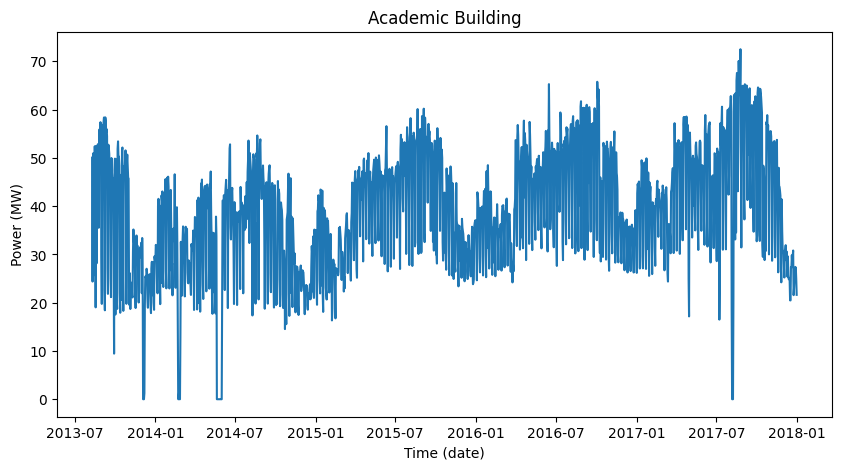

CPU times: user 540 ms, sys: 122 ms, total: 662 ms
Wall time: 651 ms


In [ ]:
%%time
fig = plt.figure(figsize=(10, 5));
plt.plot(df.index, df.Academic_MW)
plt.xlabel('Time (date)')
plt.ylabel('Power (MW)')
plt.title('Academic Building')
plt.show()

# Split a dataset into train/test sets

In [ ]:
# number of weeks in training data
nwt = 200

# Number of weeks in test data (predictions will be made and compared)
nwp = 12

# split dataset into train and test sets
def split_dataset(data, n_output):
    # slice dataset as multiples of output sequence 
    data = data.tail(n_output*nwt) # 
    # split into train and test set
    train = np.array(data.iloc[:-n_output*nwp])
    test =  np.array(data.iloc[-n_output*nwp:-n_output] )
    return train, test

In [ ]:
train, test = split_dataset(df, n_output=7)
print(train.shape)
print(test.shape)

(1316, 6)
(77, 6)


#  Format the data in the overlapping moving window format¶
We need to restrucutre the time-series data in order for training and making predictions like a supervised machine learning model. For every n_input sequence of data, the n_ouput sequence will be target values. We will also increment the sequences by 1 each time to utilise the so called overlapping window format.

In [ ]:
# convert data into input and output steps
def transform_data(train, n_input, n_output):
    X, y = [], []
    # loop over the data by 1 time step
    for i in range(len(train)):
        # define the index range of the input 
        in_end = i + n_input
        out_end = in_end + n_output
        if out_end <= len(train):
            x_input = train[i:in_end, 0] # only one feature/column is selected 
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(train[in_end:out_end, 0])
    return np.array(X), np.array(y)

# Define function for building model
In this model architecture, a one-dimensional convolutional neural network (1D CNN) is used to read and encode the input sequence. An LSTM network is then used as a decoder to make ode-step prediction for each value in the output sequence. 

In [ ]:
# build and train the model
def build_model(train, n_input, n_output):
    # transform data
    X_train, y_train = transform_data(train, n_input, n_output)
    # specify model parameters
    verbose, epochs, batch_size = 0, 100, 16
    n_features = X_train.shape[2]
    # reshape output into [samples, timesteps, features]
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(RepeatVector(n_output))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    plot_model(model=model, to_file ='model_CNN-LSTM_univariate_multistep_output.png', show_shapes=True, show_layer_names=True)
    # fit network
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# Define function for evaluating model

In [ ]:
# define function for evaluating the model
def evaluate_model(train, test, n_input, n_output):
    # fit the model on training data
    model = build_model(train, n_input, n_output)
    input_data = train.copy()
    # make predictions for each sequence (week) with a walk-forward approach
    predictions = []
    for i in range(int(len(test)/n_output)+1):
        input_x = input_data[-n_input : ,  0]
        # reshape input data 
        input_x = input_x.reshape((1, len(input_x), 1))
        # predict the sequence 
        yhat = model.predict(input_x, verbose=0)
        # get the vector output of the sequence
        yhat_sequence = yhat[0]
        # store the predicted values for each iteration in predictions
        predictions.append(yhat_sequence)
        # add the sequence of test data (for whcih prediction has just been made in the last iteration) to input data to make predictions for the next sequence
        if i < len(test)/n_output:
            input_data = np.append(input_data, test[i*n_output:(i+1)*n_output, :], axis=0) 
    # convert predictions to numpy array
    predictions = np.array(predictions)
    return predictions

# Train model and make predictions

In [ ]:
%%time
n_output = 7
n_input = n_output*3

# split into train and test
train, test = split_dataset(df, n_output)

# evaluate model and get scores
predictions = evaluate_model(train, test, n_input, n_output)
print('number of weeks predicted: ', len(predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 7, 256)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 7, 200)            3

# Visualize model architecture

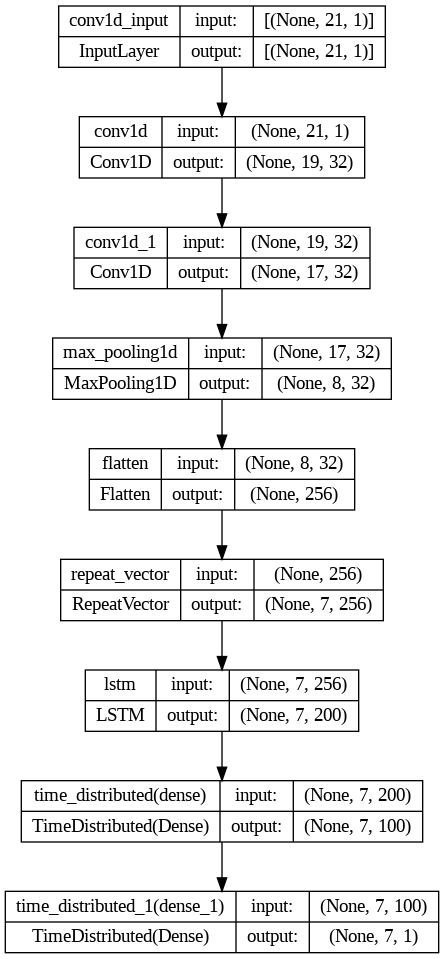

In [ ]:
Image('model_CNN-LSTM_univariate_multistep_output.png')

# Compare actual and predicted values

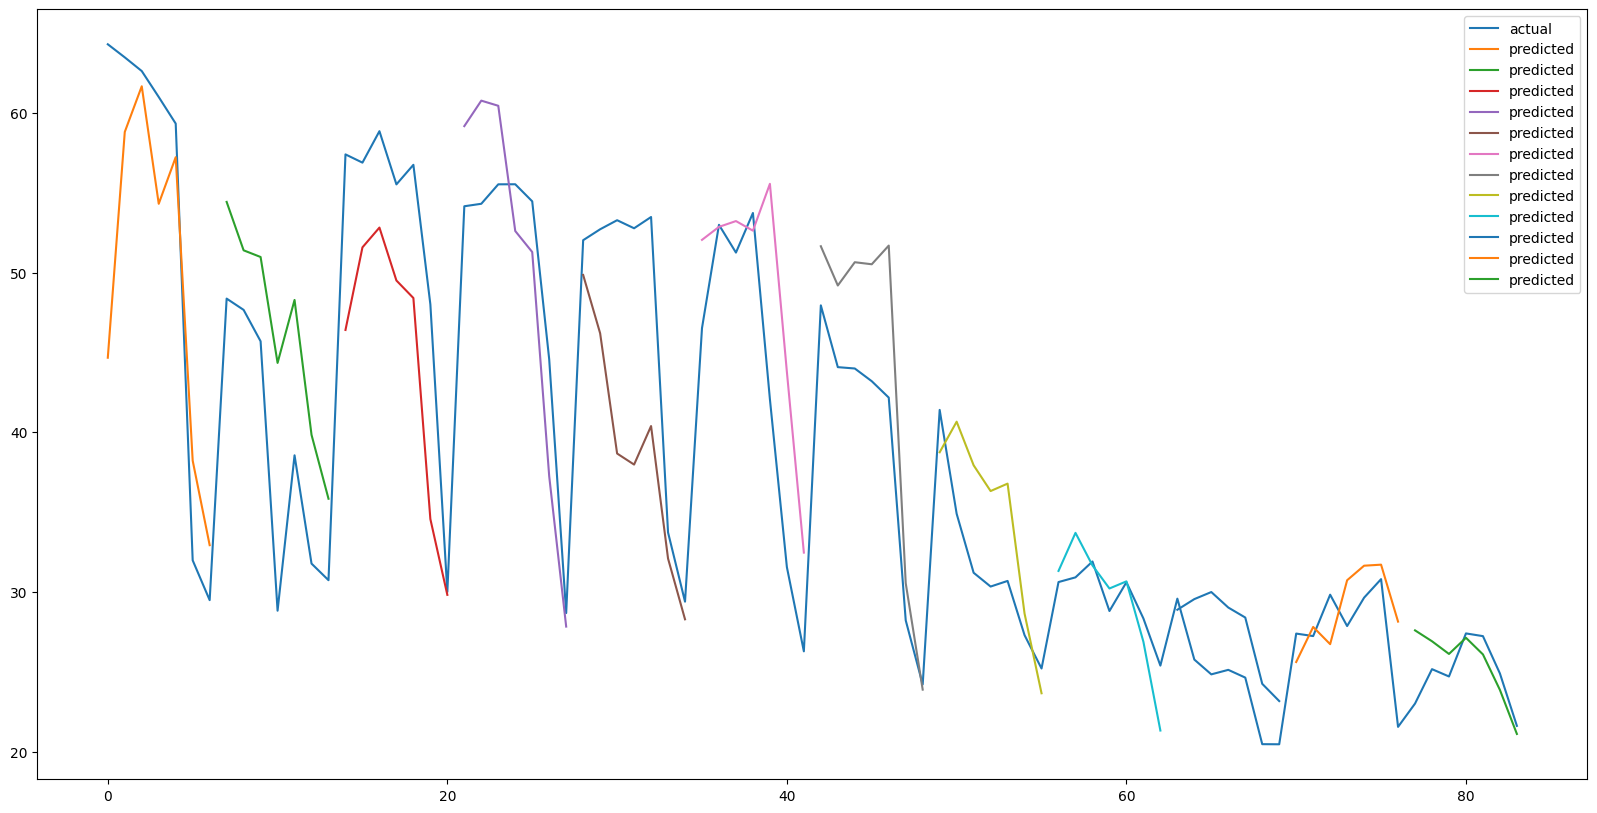

In [ ]:
def plot_predictions(actual, predicted):
    fig = plt.figure(figsize=(20,10))
    plt.plot(actual, label='actual')
    for i in range(0, len(predicted), n_output):
        plt.plot(np.array(range(0+i, i+n_output)), predicted[0+i : i+n_output], label = 'predicted')
    plt.legend()
    plt.show()

# flatten actual and predictions data 
actual = df.tail(nwp*n_output).iloc[: , 0].values
# actual_flat = actual.reshape(actual.shape[0]*actual.shape[1])
predictions_flat = predictions.reshape(predictions.shape[0]*predictions.shape[1])

# plot actual vs predicted
plot_predictions(actual, predictions_flat)

# RMSE for all sequences

In [ ]:
def return_rmse(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
    
return_rmse(actual, predictions_flat)

The root mean squared error is 6.29.


In [ ]:
time_end = time.time()
print("Notebook run time: {:.0f} seconds".format(time_end - time_start))

Notebook run time: 277 seconds
